In [1]:
import os
os.chdir("../") # run this cell only once or restart the kernel because of this!
import sys
sys.path.insert(0, "./")
from modules.settings import get_settings
from modules.metrics import create_roc_curve_fp_rate, create_roc_curve_fn_rate
import tensorflow as tf
import os
import keras
import numpy as np
import matplotlib.pyplot as plt

model_name = "final_model"

pre_pool_spectrogram_features_value = 6
batch_size = 250
min_level_for_positive = 0.5

settings = get_settings()

2024-11-01 10:48:09.649674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 10:48:09.664317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 10:48:09.668487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 10:48:09.681279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 10:48:10.374260: W tensorflow/compiler/tf2

In [2]:
model =  keras.models.load_model(os.path.join(settings.model_training_dir, model_name, 'final.keras'))

print('Load dipco dataset')
x_dipco = np.load(os.path.join(settings.dipco_dir, f'dipco_pre_pool_{pre_pool_spectrogram_features_value}_x.npy'))
y_dipco = [0 for i in range(len(x_dipco))]

predictions_negative = []
for i in range(0, len(x_dipco), batch_size):
    batch = x_dipco[i : i + batch_size]
    predictions_negative.extend(model.predict_on_batch(batch))

I0000 00:00:1730454493.714672   31981 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730454493.743264   31981 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730454493.743352   31981 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730454493.747021   31981 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730454493.747097   31981 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Load dipco dataset


I0000 00:00:1730454496.057327   32189 service.cc:146] XLA service 0x7f7f04002fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730454496.057379   32189 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-11-01 10:48:16.064549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-01 10:48:16.143437: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-01 10:48:21.929526: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[250,32,199,43]{3,2,1,0}, u8[0]{0}) custom-call(f32[250,1,199,43]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id

In [3]:
decisions_negative = [1 if p > min_level_for_positive else 0 for p in predictions_negative]

if sum(decisions_negative) == 0:
    print(f'fp rate: 0')
else:
    cm_negative = tf.math.confusion_matrix(y_dipco, decisions_negative)
    print(cm_negative)
    print(f'fp rate: {cm_negative[0][1] / len(x_dipco)}')

tf.Tensor(
[[19190     1]
 [    0     0]], shape=(2, 2), dtype=int32)
fp rate: 5.2107758845292065e-05


In [5]:
print('Load extended test dataset')
x_test = np.load(os.path.join(settings.extended_test_positives_dir, f'test_positives_pre_pool_{pre_pool_spectrogram_features_value}_x.npy'))
y_test = [1 for i in range(len(x_test))]

predictions_positive = []
for i in range(0, len(x_test), batch_size):
    batch = x_test[i : i + batch_size]
    predictions_positive.extend(model.predict_on_batch(batch))

Load extended test dataset


In [6]:
decisions_positive = [1 if p > min_level_for_positive else 0 for p in predictions_positive]

cm_positive = tf.math.confusion_matrix(y_test, decisions_positive)
print(cm_positive)
print(f'fn rate: {cm_positive[1][0] / len(x_test)}')

tf.Tensor(
[[   0    0]
 [  68 9932]], shape=(2, 2), dtype=int32)
fn rate: 0.0068


100%|██████████| 50/50 [00:00<00:00, 70.89it/s]


Text(0.0215, 0.0, '0.99')

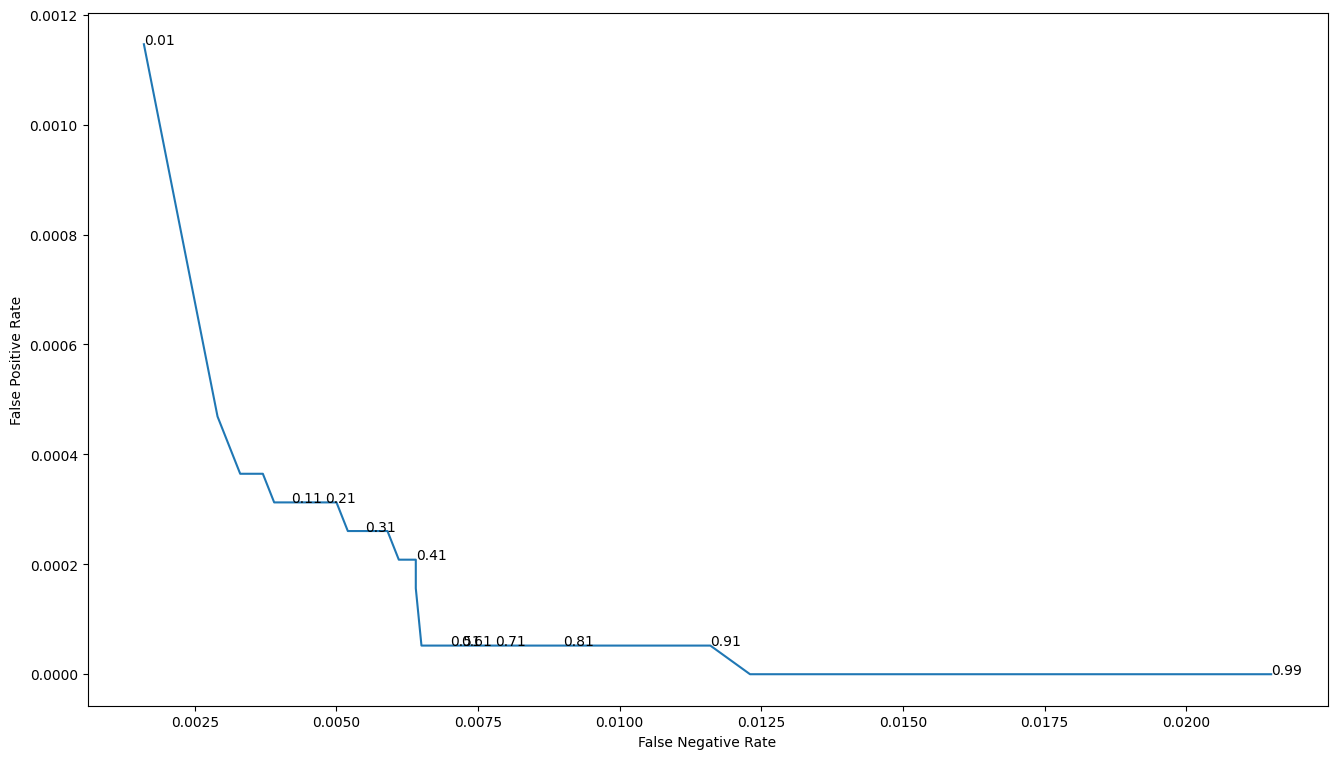

In [11]:
no_of_points = 50
point_values = np.linspace(0.01, 0.99, num=no_of_points)
roc_fp = create_roc_curve_fp_rate(predictions_negative, no_of_points)
roc_fn = create_roc_curve_fn_rate(predictions_positive, no_of_points)

plt.figure(figsize=(16,9))
plt.plot(roc_fn, roc_fp)
plt.xlabel("False Negative Rate")
plt.ylabel("False Positive Rate")

for i in range(0, no_of_points, 5):
    plt.annotate(round(point_values[i], 2), (roc_fn[i], roc_fp[i]))

i = len(point_values) - 1
plt.annotate(round(point_values[i], 2), (roc_fn[i], roc_fp[i]))